# Quantization

Make sure to go in settings > runtime and activate the GPU

## Goals

In this assignment, you will practice quantizing a classical neural network model to reduce both model size and latency. The goals of this assignment are as follows:

- Understand the basic concept of **quantization**
- Implement and apply **k-means quantization**
- Get a basic understanding of performance improvement (such as speedup) from quantization

# Setup

First, install the required packages and download the datasets and pretrained model. Here we use CIFAR10 dataset and VGG network.


In [11]:
print('Installing torchprofile...')
!pip install torchprofile 1>/dev/null
print('Installing fast-pytorch-kmeans...')
! pip install fast-pytorch-kmeans 1>/dev/null
print('All required packages have been successfully installed!')

Installing torchprofile...
Installing fast-pytorch-kmeans...
All required packages have been successfully installed!


In [12]:
import copy
import math
import random
from collections import OrderedDict, defaultdict

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from tqdm.auto import tqdm

import torch
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *

from torchprofile import profile_macs

assert torch.cuda.is_available(), \
"The current runtime does not have CUDA support." \
"Please go to menu bar (Runtime - Change runtime type) and select GPU"

In [13]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [14]:
def download_url(url, model_dir='.', overwrite=False):
    import os, sys
    from urllib.request import urlretrieve
    target_dir = url.split('/')[-1]
    model_dir = os.path.expanduser(model_dir)
    try:
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        model_dir = os.path.join(model_dir, target_dir)
        cached_file = model_dir
        if not os.path.exists(cached_file) or overwrite:
            sys.stderr.write('Downloading: "{}" to {}\n'.format(url, cached_file))
            urlretrieve(url, cached_file)
        return cached_file
    except Exception as e:
        # remove lock file so download can be executed next time.
        os.remove(os.path.join(model_dir, 'download.lock'))
        sys.stderr.write('Failed to download from url %s' % url + '\n' + str(e) + '\n')
        return None

In [15]:
class VGG(nn.Module):
  ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

  def __init__(self) -> None:
    super().__init__()

    layers = []
    counts = defaultdict(int)

    def add(name: str, layer: nn.Module) -> None:
      layers.append((f"{name}{counts[name]}", layer))
      counts[name] += 1

    in_channels = 3
    for x in self.ARCH:
      if x != 'M':
        # conv-bn-relu
        add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
        add("bn", nn.BatchNorm2d(x))
        add("relu", nn.ReLU(True))
        in_channels = x
      else:
        # maxpool
        add("pool", nn.MaxPool2d(2))
    add("avgpool", nn.AvgPool2d(2))
    self.backbone = nn.Sequential(OrderedDict(layers))
    self.classifier = nn.Linear(512, 10)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
    x = self.backbone(x)

    # avgpool: [N, 512, 2, 2] => [N, 512]
    # x = x.mean([2, 3])
    x = x.view(x.shape[0], -1)

    # classifier: [N, 512] => [N, 10]
    x = self.classifier(x)
    return x

In [16]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer and LR scheduler
    optimizer.step()
    scheduler.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

In [17]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  extra_preprocess = None
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    if extra_preprocess is not None:
        for preprocess in extra_preprocess:
            inputs = preprocess(inputs)

    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

Helpler Functions (Flops, Model Size calculation, etc.)

In [18]:
def get_model_flops(model, inputs):
    num_macs = profile_macs(model, inputs)
    return num_macs

In [19]:
def get_model_size(model: nn.Module, data_width=32):
    """
    calculate the model size in bits
    :param data_width: #bits per element
    """
    num_elements = 0
    for param in model.parameters():
        num_elements += param.numel()
    return num_elements * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

Define misc functions for verification.

In [20]:
def test_k_means_quantize(
    test_tensor=torch.tensor([
        [-0.3747,  0.0874,  0.3200, -0.4868,  0.4404],
        [-0.0402,  0.2322, -0.2024, -0.4986,  0.1814],
        [ 0.3102, -0.3942, -0.2030,  0.0883, -0.4741],
        [-0.1592, -0.0777, -0.3946, -0.2128,  0.2675],
        [ 0.0611, -0.1933, -0.4350,  0.2928, -0.1087]]),
    bitwidth=2):
    def plot_matrix(tensor, ax, title, cmap=ListedColormap(['white'])):
        ax.imshow(tensor.cpu().numpy(), vmin=-0.5, vmax=0.5, cmap=cmap)
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[1]):
            for j in range(tensor.shape[0]):
                text = ax.text(j, i, f'{tensor[i, j].item():.2f}',
                                ha="center", va="center", color="k")

    fig, axes = plt.subplots(1,2, figsize=(8, 12))
    ax_left, ax_right = axes.ravel()

    plot_matrix(test_tensor, ax_left, 'original tensor')

    num_unique_values_before_quantization = test_tensor.unique().numel()
    k_means_quantize(test_tensor, bitwidth=bitwidth)
    num_unique_values_after_quantization = test_tensor.unique().numel()
    print('* Test k_means_quantize()')
    print(f'    target bitwidth: {bitwidth} bits')
    print(f'        num unique values before k-means quantization: {num_unique_values_before_quantization}')
    print(f'        num unique values after  k-means quantization: {num_unique_values_after_quantization}')
    assert num_unique_values_after_quantization == min((1 << bitwidth), num_unique_values_before_quantization)
    print('* Test passed.')

    plot_matrix(test_tensor, ax_right, f'{bitwidth}-bit k-means quantized tensor', cmap='tab20c')
    fig.tight_layout()
    plt.show()

In [21]:
def test_linear_quantize(
    test_tensor=torch.tensor([
        [ 0.0523,  0.6364, -0.0968, -0.0020,  0.1940],
        [ 0.7500,  0.5507,  0.6188, -0.1734,  0.4677],
        [-0.0669,  0.3836,  0.4297,  0.6267, -0.0695],
        [ 0.1536, -0.0038,  0.6075,  0.6817,  0.0601],
        [ 0.6446, -0.2500,  0.5376, -0.2226,  0.2333]]),
    quantized_test_tensor=torch.tensor([
        [-1,  1, -1, -1,  0],
        [ 1,  1,  1, -2,  0],
        [-1,  0,  0,  1, -1],
        [-1, -1,  1,  1, -1],
        [ 1, -2,  1, -2,  0]], dtype=torch.int8),
    real_min=-0.25, real_max=0.75, bitwidth=2, scale=1/3, zero_point=-1):
    def plot_matrix(tensor, ax, title, vmin=0, vmax=1, cmap=ListedColormap(['white'])):
        ax.imshow(tensor.cpu().numpy(), vmin=vmin, vmax=vmax, cmap=cmap)
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[0]):
            for j in range(tensor.shape[1]):
                datum = tensor[i, j].item()
                if isinstance(datum, float):
                    text = ax.text(j, i, f'{datum:.2f}',
                                    ha="center", va="center", color="k")
                else:
                    text = ax.text(j, i, f'{datum}',
                                    ha="center", va="center", color="k")
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    fig, axes = plt.subplots(1,3, figsize=(10, 32))
    plot_matrix(test_tensor, axes[0], 'original tensor', vmin=real_min, vmax=real_max)
    _quantized_test_tensor = linear_quantize(
        test_tensor, bitwidth=bitwidth, scale=scale, zero_point=zero_point)
    _reconstructed_test_tensor = scale * (_quantized_test_tensor.float() - zero_point)
    print('* Test linear_quantize()')
    print(f'    target bitwidth: {bitwidth} bits')
    print(f'        scale: {scale}')
    print(f'        zero point: {zero_point}')
    assert _quantized_test_tensor.equal(quantized_test_tensor)
    print('* Test passed.')
    plot_matrix(_quantized_test_tensor, axes[1], f'2-bit linear quantized tensor',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(_reconstructed_test_tensor, axes[2], f'reconstructed tensor',
                vmin=real_min, vmax=real_max, cmap='tab20c')
    fig.tight_layout()
    plt.show()


In [22]:
def test_quantized_fc(
    input=torch.tensor([
        [0.6118, 0.7288, 0.8511, 0.2849, 0.8427, 0.7435, 0.4014, 0.2794],
        [0.3676, 0.2426, 0.1612, 0.7684, 0.6038, 0.0400, 0.2240, 0.4237],
        [0.6565, 0.6878, 0.4670, 0.3470, 0.2281, 0.8074, 0.0178, 0.3999],
        [0.1863, 0.3567, 0.6104, 0.0497, 0.0577, 0.2990, 0.6687, 0.8626]]),
    weight=torch.tensor([
        [ 1.2626e-01, -1.4752e-01,  8.1910e-02,  2.4982e-01, -1.0495e-01,
         -1.9227e-01, -1.8550e-01, -1.5700e-01],
        [ 2.7624e-01, -4.3835e-01,  5.1010e-02, -1.2020e-01, -2.0344e-01,
          1.0202e-01, -2.0799e-01,  2.4112e-01],
        [-3.8216e-01, -2.8047e-01,  8.5238e-02, -4.2504e-01, -2.0952e-01,
          3.2018e-01, -3.3619e-01,  2.0219e-01],
        [ 8.9233e-02, -1.0124e-01,  1.1467e-01,  2.0091e-01,  1.1438e-01,
         -4.2427e-01,  1.0178e-01, -3.0941e-04],
        [-1.8837e-02, -2.1256e-01, -4.5285e-01,  2.0949e-01, -3.8684e-01,
         -1.7100e-01, -4.5331e-01, -2.0433e-01],
        [-2.0038e-01, -5.3757e-02,  1.8997e-01, -3.6866e-01,  5.5484e-02,
          1.5643e-01, -2.3538e-01,  2.1103e-01],
        [-2.6875e-01,  2.4984e-01, -2.3514e-01,  2.5527e-01,  2.0322e-01,
          3.7675e-01,  6.1563e-02,  1.7201e-01],
        [ 3.3541e-01, -3.3555e-01, -4.3349e-01,  4.3043e-01, -2.0498e-01,
         -1.8366e-01, -9.1553e-02, -4.1168e-01]]),
    bias=torch.tensor([ 0.1954, -0.2756,  0.3113,  0.1149,  0.4274,  0.2429, -0.1721, -0.2502]),
    quantized_bias=torch.tensor([ 3, -2,  3,  1,  3,  2, -2, -2], dtype=torch.int32),
    shifted_quantized_bias=torch.tensor([-1,  0, -3, -1, -3,  0,  2, -4], dtype=torch.int32),
    calc_quantized_output=torch.tensor([
        [ 0, -1,  0, -1, -1,  0,  1, -2],
        [ 0,  0, -1,  0,  0,  0,  0, -1],
        [ 0,  0,  0, -1,  0,  0,  0, -1],
        [ 0,  0,  0,  0,  0,  1, -1, -2]], dtype=torch.int8),
    bitwidth=2, batch_size=4, in_channels=8, out_channels=8):
    def plot_matrix(tensor, ax, title, vmin=0, vmax=1, cmap=ListedColormap(['white'])):
        ax.imshow(tensor.cpu().numpy(), vmin=vmin, vmax=vmax, cmap=cmap)
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[0]):
            for j in range(tensor.shape[1]):
                datum = tensor[i, j].item()
                if isinstance(datum, float):
                    text = ax.text(j, i, f'{datum:.2f}',
                                    ha="center", va="center", color="k")
                else:
                    text = ax.text(j, i, f'{datum}',
                                    ha="center", va="center", color="k")

    output = torch.nn.functional.linear(input, weight, bias)

    quantized_weight, weight_scale, weight_zero_point = \
        linear_quantize_weight_per_channel(weight, bitwidth)
    quantized_input, input_scale, input_zero_point = \
        linear_quantize_feature(input, bitwidth)
    _quantized_bias, bias_scale, bias_zero_point = \
        linear_quantize_bias_per_output_channel(bias, weight_scale, input_scale)
    assert _quantized_bias.equal(_quantized_bias)
    _shifted_quantized_bias = \
        shift_quantized_linear_bias(quantized_bias, quantized_weight, input_zero_point)
    assert _shifted_quantized_bias.equal(shifted_quantized_bias)
    quantized_output, output_scale, output_zero_point = \
        linear_quantize_feature(output, bitwidth)

    _calc_quantized_output = quantized_linear(
        quantized_input, quantized_weight, shifted_quantized_bias,
        bitwidth, bitwidth,
        input_zero_point, output_zero_point,
        input_scale, weight_scale, output_scale)
    assert _calc_quantized_output.equal(calc_quantized_output)

    reconstructed_weight = weight_scale * (quantized_weight.float() - weight_zero_point)
    reconstructed_input = input_scale * (quantized_input.float() - input_zero_point)
    reconstructed_bias = bias_scale * (quantized_bias.float() - bias_zero_point)
    reconstructed_calc_output = output_scale * (calc_quantized_output.float() - output_zero_point)

    fig, axes = plt.subplots(3,3, figsize=(15, 12))
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    plot_matrix(weight, axes[0, 0], 'original weight', vmin=-0.5, vmax=0.5)
    plot_matrix(input.t(), axes[1, 0], 'original input', vmin=0, vmax=1)
    plot_matrix(output.t(), axes[2, 0], 'original output', vmin=-1.5, vmax=1.5)
    plot_matrix(quantized_weight, axes[0, 1], f'{bitwidth}-bit linear quantized weight',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(quantized_input.t(), axes[1, 1], f'{bitwidth}-bit linear quantized input',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(calc_quantized_output.t(), axes[2, 1], f'quantized output from quantized_linear()',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(reconstructed_weight, axes[0, 2], f'reconstructed weight',
                vmin=-0.5, vmax=0.5, cmap='tab20c')
    plot_matrix(reconstructed_input.t(), axes[1, 2], f'reconstructed input',
                vmin=0, vmax=1, cmap='tab20c')
    plot_matrix(reconstructed_calc_output.t(), axes[2, 2], f'reconstructed output',
                vmin=-1.5, vmax=1.5, cmap='tab20c')

    print('* Test quantized_fc()')
    print(f'    target bitwidth: {bitwidth} bits')
    print(f'      batch size: {batch_size}')
    print(f'      input channels: {in_channels}')
    print(f'      output channels: {out_channels}')
    print('* Test passed.')
    fig.tight_layout()
    plt.show()

Load Pretrained Model

In [23]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [24]:
checkpoint_url = "https://hanlab.mit.edu/files/course/labs/vgg.cifar.pretrained.pth"
checkpoint = torch.load(download_url(checkpoint_url), map_location="cpu")
model = VGG().cuda()
print(f"=> loading checkpoint '{checkpoint_url}'")
model.load_state_dict(checkpoint['state_dict'])
recover_model = lambda : model.load_state_dict(checkpoint['state_dict'])

Downloading: "https://hanlab.mit.edu/files/course/labs/vgg.cifar.pretrained.pth" to ./vgg.cifar.pretrained.pth


=> loading checkpoint 'https://hanlab.mit.edu/files/course/labs/vgg.cifar.pretrained.pth'


In [25]:
image_size = 32
transforms = {
    "train": Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    "test": ToTensor(),
}
dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )
dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=512,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )

100%|██████████| 170498071/170498071 [00:03<00:00, 49095591.60it/s]


Extracting data/cifar10/cifar-10-python.tar.gz to data/cifar10
Files already downloaded and verified


# Let's First Evaluate the Accuracy and Model Size of the FP32 Model

In [26]:
fp32_model_accuracy = evaluate(model, dataloader['test'])
fp32_model_size = get_model_size(model)
print(f"fp32 model has accuracy={fp32_model_accuracy:.2f}%")
print(f"fp32 model has size={fp32_model_size/MiB:.2f} MiB")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

fp32 model has accuracy=92.95%
fp32 model has size=35.20 MiB


# K-Means Quantization

Network quantization compresses the network by reducing the bits per weight required to represent the deep network. The quantized network can have a faster inference speed with hardware support.

In this section, we will explore the K-means quantization for neural networks as in [Deep Compression: Compressing Deep Neural Networks With Pruning, Trained Quantization
And Huffman Coding](https://arxiv.org/pdf/1510.00149.pdf).


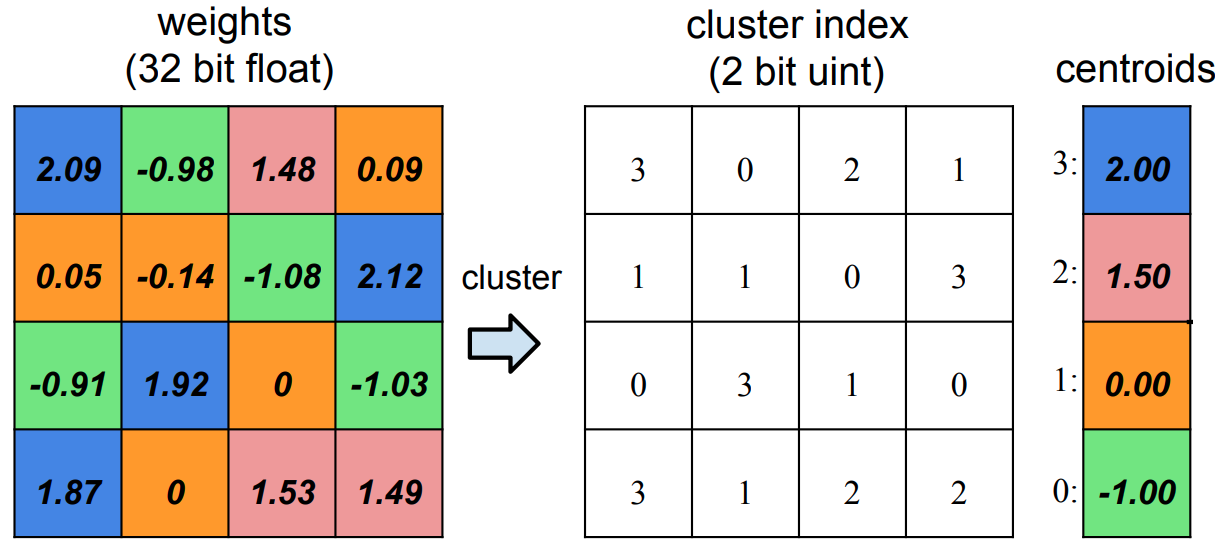

A $n$-bit k-means quantization will divide synapses into $2^n$ clusters, and synapses in the same cluster will share the same weight value.

Therefore, k-means quantization will create a codebook, inlcuding
*   `centroids`: $2^n$ fp32 cluster centers.
*   `labels`: a $n$-bit integer tensor with the same #elements of the original fp32 weights tensor. Each integer indicates which cluster it belongs to.

During the inference, a fp32 tensor is generated based on the codebook for inference:

> ***quantized_weight* = *codebook.centroids*\[*codebook.labels*\].view_as(weight)**

In [27]:
from collections import namedtuple

Codebook = namedtuple('Codebook', ['centroids', 'labels'])

## Question 1

Please complete the following K-Means quantization function.

In [28]:
from fast_pytorch_kmeans import KMeans

def k_means_quantize(fp32_tensor: torch.Tensor, bitwidth=4, codebook=None):
    """
    quantize tensor using k-means clustering
    :param fp32_tensor:
    :param bitwidth: [int] quantization bit width, default=4
    :param codebook: [Codebook] (the cluster centroids, the cluster label tensor)
    :return:
        [Codebook = (centroids, labels)]
            centroids: [torch.(cuda.)FloatTensor] the cluster centroids
            labels: [torch.(cuda.)LongTensor] cluster label tensor
    """
    if codebook is None:
        # get number of clusters based on the quantization precision
        # hint: one line of code
        n_clusters = 2**bitwidth
        # use k-means to get the quantization centroids
        kmeans = KMeans(n_clusters=n_clusters, mode='euclidean', verbose=0)
        labels = kmeans.fit_predict(fp32_tensor.view(-1, 1)).to(torch.long)
        centroids = kmeans.centroids.to(torch.float).view(-1)
        codebook = Codebook(centroids, labels)
    # decode the codebook into k-means quantized tensor for inference
    # hint: one line of code
    quantized_tensor = codebook.centroids[codebook.labels].clone().detach()
    fp32_tensor.set_(quantized_tensor.view_as(fp32_tensor))
    return codebook

Let's verify the functionality of defined k-means quantization by applying the function above on a dummy tensor.

* Test k_means_quantize()
    target bitwidth: 2 bits
        num unique values before k-means quantization: 25
        num unique values after  k-means quantization: 4
* Test passed.


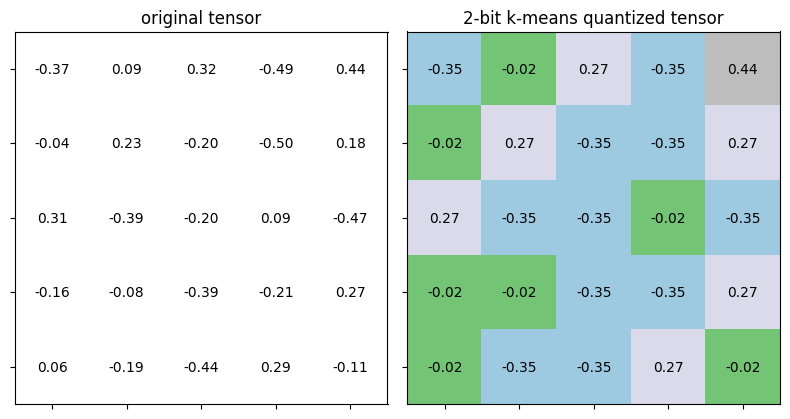

In [29]:
test_k_means_quantize()

## K-Means Quantization on Whole Model

Similar to what we did in the pruning section, we now wrap the k-means quantization function into a class for quantizing the whole model. In class `KMeansQuantizer`, we have to keep a record of the codebooks (i.e., `centroids` and `labels`) so that we could apply or update the codebooks whenever the model weights change.

In [31]:
from torch.nn import parameter
class KMeansQuantizer:
    def __init__(self, model : nn.Module, bitwidth=4):
        self.codebook = KMeansQuantizer.quantize(model, bitwidth)

    @torch.no_grad()
    def apply(self, model, update_centroids):
        for name, param in model.named_parameters():
            if name in self.codebook:
                if update_centroids:
                    update_codebook(param, codebook=self.codebook[name])
                self.codebook[name] = k_means_quantize(
                    param, codebook=self.codebook[name])

    @staticmethod
    @torch.no_grad()
    def quantize(model: nn.Module, bitwidth=4):
        codebook = dict()
        if isinstance(bitwidth, dict):
            for name, param in model.named_parameters():
                if name in bitwidth:
                    codebook[name] = k_means_quantize(param, bitwidth=bitwidth[name])
        else:
            for name, param in model.named_parameters():
                if param.dim() > 1:
                    codebook[name] = k_means_quantize(param, bitwidth=bitwidth)
        return codebook

Now let's quantize model into 8 bits, 4 bits and 2 bits using K-Means Quantization. *Note that we ignore the storage for codebooks when calculating the model size.*

Note that the storage for codebooks is ignored when calculating the model size.
k-means quantizing model into 8 bits
    8-bit k-means quantized model has size=8.80 MiB


eval:   0%|          | 0/20 [00:00<?, ?it/s]

    8-bit k-means quantized model has accuracy=92.85%
k-means quantizing model into 6 bits
    6-bit k-means quantized model has size=6.60 MiB


eval:   0%|          | 0/20 [00:00<?, ?it/s]

    6-bit k-means quantized model has accuracy=89.49%
k-means quantizing model into 4 bits
    4-bit k-means quantized model has size=4.40 MiB


eval:   0%|          | 0/20 [00:00<?, ?it/s]

    4-bit k-means quantized model has accuracy=77.49%
k-means quantizing model into 2 bits
    2-bit k-means quantized model has size=2.20 MiB


eval:   0%|          | 0/20 [00:00<?, ?it/s]

    2-bit k-means quantized model has accuracy=31.41%


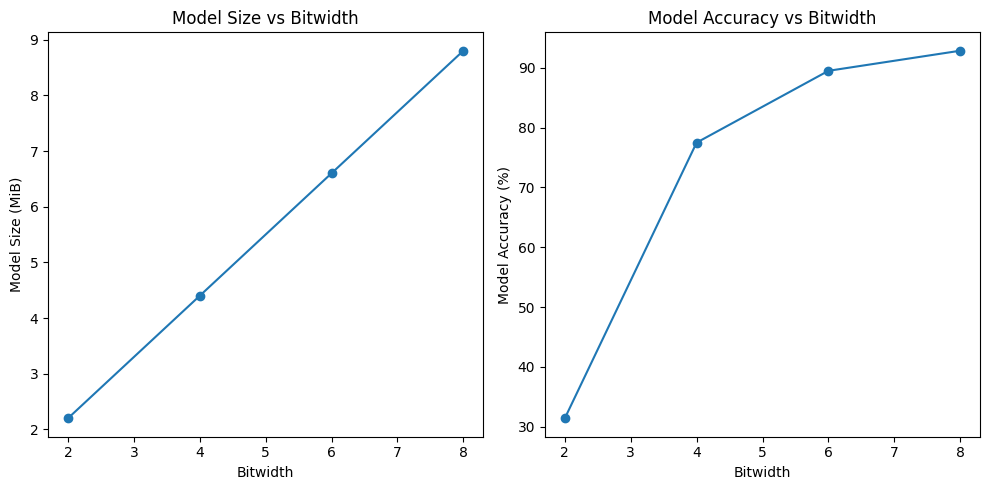

In [35]:
import matplotlib.pyplot as plt

print('Note that the storage for codebooks is ignored when calculating the model size.')

bitwidths = [8, 6,4, 2]
quantizers = dict()
model_sizes = []
model_accuracies = []

for bitwidth in bitwidths:
    recover_model()
    print(f'k-means quantizing model into {bitwidth} bits')
    quantizer = KMeansQuantizer(model, bitwidth)
    quantized_model_size = get_model_size(model, bitwidth)
    print(f"    {bitwidth}-bit k-means quantized model has size={quantized_model_size/MiB:.2f} MiB")
    quantized_model_accuracy = evaluate(model, dataloader['test'])
    print(f"    {bitwidth}-bit k-means quantized model has accuracy={quantized_model_accuracy:.2f}%")
    quantizers[bitwidth] = quantizer
    model_sizes.append(quantized_model_size/MiB)
    model_accuracies.append(quantized_model_accuracy)

# Plotting model size
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(bitwidths, model_sizes, marker='o')
plt.xlabel('Bitwidth')
plt.ylabel('Model Size (MiB)')
plt.title('Model Size vs Bitwidth')

# Plotting model accuracy
plt.subplot(1, 2, 2)
plt.plot(bitwidths, model_accuracies, marker='o')
plt.xlabel('Bitwidth')
plt.ylabel('Model Accuracy (%)')
plt.title('Model Accuracy vs Bitwidth')

plt.tight_layout()
plt.show()


## Trained K-Means Quantization

As we can see from the results of last cell, the accuracy significantly drops when quantizing the model into lower bits. Therefore, we have to perform quantization-aware training to recover the accuracy.

During the k-means quantization-aware training, the centroids are also updated, which is proposed in [Deep Compression: Compressing Deep Neural Networks With Pruning, Trained Quantization
And Huffman Coding](https://arxiv.org/pdf/1510.00149.pdf).

The gradient for the centroids is calculated as,

> $\frac{\partial \mathcal{L} }{\partial C_k} = \sum_{j} \frac{\partial \mathcal{L} }{\partial W_{j}} \frac{\partial W_{j} }{\partial C_k} = \sum_{j} \frac{\partial \mathcal{L} }{\partial W_{j}} \mathbf{1}(I_{j}=k)$

where $\mathcal{L}$ is the loss, $C_k$ is *k*-th centroid, $I_{j}$ is the label for weight $W_{j}$. $\mathbf{1}()$ is the indicator function, and $\mathbf{1}(I_{j}=k)$ means $1\;\mathrm{if}\;I_{j}=k\;\mathrm{else}\;0$, *i.e.*, $I_{j}==k$.

Here in the lab, **for simplicity**, we directly update the centroids according to the latest weights:

> $C_k = \frac{\sum_{j}W_{j}\mathbf{1}(I_{j}=k)}{\sum_{j}\mathbf{1}(I_{j}=k)}$

### Question 3

Please complete the following codebook update function.

**Hint**:

The above equation for updating centroids is indeed using the `mean` of weights in the same cluster to be the updated centroid value.

In [36]:
def update_codebook(fp32_tensor: torch.Tensor, codebook: Codebook):
    """
    update the centroids in the codebook using updated fp32_tensor
    :param fp32_tensor: [torch.(cuda.)Tensor]
    :param codebook: [Codebook] (the cluster centroids, the cluster label tensor)
    """
    n_clusters = codebook.centroids.numel()
    fp32_tensor = fp32_tensor.view(-1)
    for k in range(n_clusters):
      codebook.centroids[k] = fp32_tensor[codebook.labels == k].mean()

Now let's run the following code cell to finetune the k-means quantized model to recover the accuracy. We will stop finetuning if accuracy drop is less than 0.5.

In [39]:
accuracy_drop_threshold = 0.5
quantizers_before_finetune = copy.deepcopy(quantizers)
quantizers_after_finetune = quantizers

model_sizes_before = []
model_sizes_after = []
model_accuracies_before = []
model_accuracies_after = []

for bitwidth in [8, 6, 4, 2]:
    recover_model()
    quantizer = quantizers[bitwidth]
    print(f'k-means quantizing model into {bitwidth} bits')
    quantizer.apply(model, update_centroids=False)
    quantized_model_size = get_model_size(model, bitwidth)
    print(f"    {bitwidth}-bit k-means quantized model has size={quantized_model_size/MiB:.2f} MiB")
    quantized_model_accuracy = evaluate(model, dataloader['test'])
    print(f"    {bitwidth}-bit k-means quantized model has accuracy={quantized_model_accuracy:.2f}% before quantization-aware training ")

    model_sizes_before.append(quantized_model_size/MiB)
    model_accuracies_before.append(quantized_model_accuracy)

    accuracy_drop = fp32_model_accuracy - quantized_model_accuracy
    if accuracy_drop > accuracy_drop_threshold:
        print(f"        Quantization-aware training due to accuracy drop={accuracy_drop:.2f}% is larger than threshold={accuracy_drop_threshold:.2f}%")
        num_finetune_epochs = 5
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
        criterion = nn.CrossEntropyLoss()
        best_accuracy = 0
        epoch = num_finetune_epochs
        while accuracy_drop > accuracy_drop_threshold and epoch > 0:
            train(model, dataloader['train'], criterion, optimizer, scheduler,
                  callbacks=[lambda: quantizer.apply(model, update_centroids=True)])
            model_accuracy = evaluate(model, dataloader['test'])
            is_best = model_accuracy > best_accuracy
            best_accuracy = max(model_accuracy, best_accuracy)
            print(f'        Epoch {num_finetune_epochs-epoch} Accuracy {model_accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')
            accuracy_drop = fp32_model_accuracy - best_accuracy
            epoch -= 1

        model_sizes_after.append(get_model_size(model, bitwidth)/MiB)
        model_accuracies_after.append(best_accuracy)
    else:
        model_sizes_after.append(quantized_model_size/MiB)
        model_accuracies_after.append(quantized_model_accuracy)
        print(f"        No need for quantization-aware training since accuracy drop={accuracy_drop:.2f}% is smaller than threshold={accuracy_drop_threshold:.2f}%")

k-means quantizing model into 8 bits
    8-bit k-means quantized model has size=8.80 MiB


eval:   0%|          | 0/20 [00:00<?, ?it/s]

    8-bit k-means quantized model has accuracy=92.85% before quantization-aware training 
        No need for quantization-aware training since accuracy drop=0.10% is smaller than threshold=0.50%
k-means quantizing model into 6 bits
    6-bit k-means quantized model has size=6.60 MiB


eval:   0%|          | 0/20 [00:00<?, ?it/s]

    6-bit k-means quantized model has accuracy=89.91% before quantization-aware training 
        Quantization-aware training due to accuracy drop=3.04% is larger than threshold=0.50%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

        Epoch 0 Accuracy 92.66% / Best Accuracy: 92.66%
k-means quantizing model into 4 bits
    4-bit k-means quantized model has size=4.40 MiB


eval:   0%|          | 0/20 [00:00<?, ?it/s]

    4-bit k-means quantized model has accuracy=81.21% before quantization-aware training 
        Quantization-aware training due to accuracy drop=11.74% is larger than threshold=0.50%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

        Epoch 0 Accuracy 92.21% / Best Accuracy: 92.21%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

        Epoch 1 Accuracy 92.42% / Best Accuracy: 92.42%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

        Epoch 2 Accuracy 92.48% / Best Accuracy: 92.48%
k-means quantizing model into 2 bits
    2-bit k-means quantized model has size=2.20 MiB


eval:   0%|          | 0/20 [00:00<?, ?it/s]

    2-bit k-means quantized model has accuracy=34.73% before quantization-aware training 
        Quantization-aware training due to accuracy drop=58.22% is larger than threshold=0.50%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

        Epoch 0 Accuracy 90.93% / Best Accuracy: 90.93%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

        Epoch 1 Accuracy 91.29% / Best Accuracy: 91.29%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

        Epoch 2 Accuracy 91.51% / Best Accuracy: 91.51%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

        Epoch 3 Accuracy 91.50% / Best Accuracy: 91.51%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

        Epoch 4 Accuracy 91.69% / Best Accuracy: 91.69%


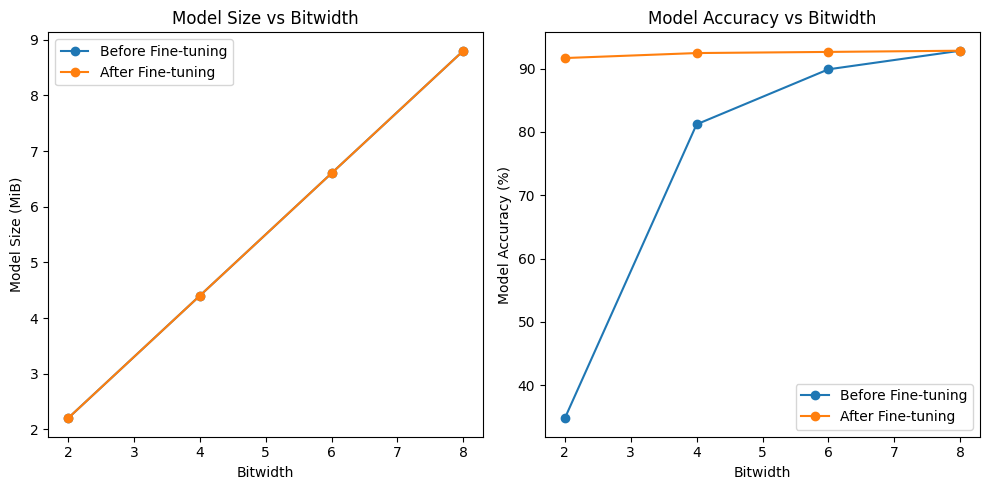

In [40]:
# Plotting model size
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(bitwidths, model_sizes_before, marker='o', label='Before Fine-tuning')
plt.plot(bitwidths, model_sizes_after, marker='o', label='After Fine-tuning')
plt.xlabel('Bitwidth')
plt.ylabel('Model Size (MiB)')
plt.title('Model Size vs Bitwidth')
plt.legend()

# Plotting model accuracy
plt.subplot(1, 2, 2)
plt.plot(bitwidths, model_accuracies_before, marker='o', label='Before Fine-tuning')
plt.plot(bitwidths, model_accuracies_after, marker='o', label='After Fine-tuning')
plt.xlabel('Bitwidth')
plt.ylabel('Model Accuracy (%)')
plt.title('Model Accuracy vs Bitwidth')
plt.legend()

plt.tight_layout()
plt.show()